# Migration and weather, is there a relation?

I wanted to tackle a question that sparked my curiosity, is there a relation between the weather of certain departments in Colombia and the amount of immigrants there? 

To solve said question, I searched for datasets relating weather (__[temperature](http://atlas.ideam.gov.co/cclimatologicas/info/tmedmen.html)__ and __[rain precipitation](http://atlas.ideam.gov.co/cclimatologicas/info/tmedmen.html)__) and the amount of __[Venezuelan immigrants](https://data.amerigeoss.org/dataset/base-de-poblacion-migrante-venezolana-en-colombia/resource/d898d369-9ff2-4f36-aa74-966170aad1d8)__ in each municipality of Colombia.

I came across with not that many datasets, when it came to the weather topic, I found a lot of information in the IDEAM (Environmental, Hydrology, and Meteorology studies institute) colombian website, but most of that information was PDF's graphs and not datasets per se, what i was able to find was a website where the user could download specific datasets for an specific month of the year, so i chose february 2022 to download the weather info containing data about rain precipitation and mean temperature for municipalities where IDEAM had the sensor (at least one for each one of the 32 departments). 

While looking for the migrants information, it was easier to find, i found a dataset where I found a very complete information about migrants in each municipality of Colombia for the month February 2022 as well (a very strong reason to choose that month for the weather data). 

I started by doing some pre-processing of the data, cleaning it and renaming the columns so I could merge it later. I used Geopandas because I thought it was a very efficient and visually appealing way to portray the information about the departments and the inmigration phenomena ocurring in Colombia in recent years.

This code might be updated later. 

This code was made by Juan Camilo Muñoz - https://www.linkedin.com/in/jucmunozar/

In [2]:
import numpy as np
import pandas as pd

Three datasets were used during the making of this code and they were as such: 
- df1: Dataset containing the amount of venezuelan inmigrants in each of the municipalities and departments in Colombia during 2021 and 2022 
- df2: Dataset that has the information of rain precipitation in mm for the month of February 2022 in certain municipalities of Colombia 
- df3: Dataset with the information of mean temperature in celsius for the month of February 2022 in certain municipalities of Colombia 
- gdf/coldf: Geopandas DataFrame containing information about Colombia's departments used to represent where inmigrants stayed in the country


In [3]:
# Inmigrant population in Feb 2022
df1 = pd.read_csv('population.csv', encoding='latin-1')
# df1.head()

In [4]:
# Removing the whitespaces left in the columns ('Departamento' was previously 'Departamento_')
df1 = df1.rename(columns=lambda x: x.strip())


In [5]:
df1=df1.reset_index()
df1=df1.rename({'Departamento':'department'},axis=1)
df1['department']=df1['department'].str.lower()

In [6]:
string_mapping = {'bogota, d.c.': 'cundinamarca',
                  'archipielago de san andres, providencia y santa catalina': 'san andres y providencia',
                  'nariño': 'narino',
                  'norte de santander': 'norte santander',
                  'cordoba':'córdoba'
                  }

# Loop through each row in the DataFrame
for index, row in df1.iterrows():
    # Loop through each column in the row
    for col in df1.columns:
        # Check if the cell contains an old string value
        if row[col] in string_mapping.keys():
            # Update the cell with the new string value
            df1.loc[index, col] = string_mapping[row[col]]

In [7]:
df1=df1.rename({'Poblacion Febrero 2022':'inmigrant population'}, axis=1)

In [8]:
df1 = df1.groupby('department')['inmigrant population'].sum()

In [9]:
df1 = df1.reset_index(drop=False)


In [10]:
#mm of rain in feb 2022
df2 = pd.read_csv('pmes_tab.csv', encoding='latin-1', header=(1))
df2 = df2.rename(columns=lambda x: x.strip())


In [11]:
df2=df2.rename({'DEPTO':'department'},axis=1)
df2['department']=df2['department'].str.lower()

In [12]:
df2 = df2.drop_duplicates(subset=['department'],keep='last')


In [13]:
df2 = df2.groupby('department')['FEB'].sum().reset_index()

In [14]:
df2.drop(index=29, inplace=True)
df2.reset_index(inplace=True, drop=True)

In [15]:
df3 = pd.read_csv('tmed_tab.csv', encoding='latin-1',header=(1))
df3 = df3.rename(columns=lambda x: x.strip())

In [16]:
df3=df3.rename({'DEPTO':'department'},axis=1)
df3['department']=df3['department'].str.lower()

In [17]:
df3 = df3.drop_duplicates(subset=['department'],keep='last')


In [18]:
df3 = df3.groupby('department')['FEB'].sum().reset_index()

In [19]:
# Drop a repeated index that uses 'Valle' and 'Valle del Cauca' as two departments when they are the same
df3.drop(index=29, inplace=True)
df3.reset_index(inplace=True, drop=True)



In [20]:
df4 = pd.merge(df2,df3, on = 'department')

In [21]:
df4 = df4.rename({'DEPTO':'department','FEB_x':'mm rain','FEB_y':'temperature(celsius)'}, axis=1)

In [22]:
df4['department']=df4['department'].str.lower()

In [23]:
old_string = 'san andres y pr'
new_string = 'san andres y providencia'

# Loop through each row in the DataFrame
for index, row in df4.iterrows():
    # Check if the old string exists in column 'A'
    if old_string in row['department']:
        # Update the cell with the new string
        df4.at[index, 'department'] = row['department'].replace(old_string, new_string)

In [24]:
df4 = pd.merge(df1,df4, on = 'department', how='inner')

In [25]:
import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

In [26]:
col = gpd.read_file('./').to_crs(epsg=3116)
coldf = pd.DataFrame(col)


In [27]:
coldf['DPTO_CNMBR'] = coldf['DPTO_CNMBR'].str.lower()

In [28]:
string_mapping = {'caquetá': 'caqueta',
                  'archipiélago de san andrés, providencia y santa catalina': 'san andres y providencia',
                  'nariño': 'narino',
                  'norte de santander': 'norte santander',
                  'guainía':'guainia',
                  'vaupés':'vaupes',
                  'chocó':'choco',
                  'bolívar':'bolivar',
                  'boyacá':'boyaca',
                  'bogotá, d.c.':'cundinamarca',
                  'atlántico':'atlantico'
                  }

# Loop through each row in the DataFrame
for index, row in coldf.iterrows():
    # Loop through each column in the row
    for col in coldf.columns:
        # Check if the cell contains an old string value
        if row[col] in string_mapping.keys():
            # Update the cell with the new string value
            coldf.loc[index, col] = string_mapping[row[col]]

In [29]:
coldf.loc[27] = coldf.loc[25].copy()


In [30]:
coldf.drop(index=27, inplace=True)


In [31]:
coldf = coldf.reset_index()

In [32]:
coldf = coldf.rename({'DPTO_CNMBR':'department'}, axis=1)

In [33]:
coldf = coldf[['department', 'geometry']]

In [34]:
coldf = pd.merge(df4, coldf, on='department')

In [35]:
gdf = gpd.GeoDataFrame(coldf, geometry='geometry')


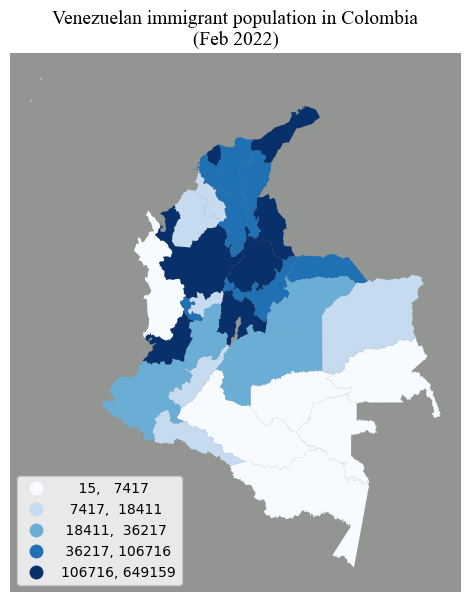

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('Venezuelan immigrant population in Colombia\n(Feb 2022)',fontsize=14, fontname="Times New Roman")

gdf.plot(column='inmigrant population', legend=True, ax=ax, cmap='Blues', scheme='quantiles',  
         legend_kwds={'loc': 'lower left', 'fmt':"{:.0f}"})

ax.set_facecolor('xkcd:grey')

plt.xticks([])
plt.yticks([])


for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()




In [37]:
top = df1
top_10 = top.nlargest(10, 'inmigrant population')

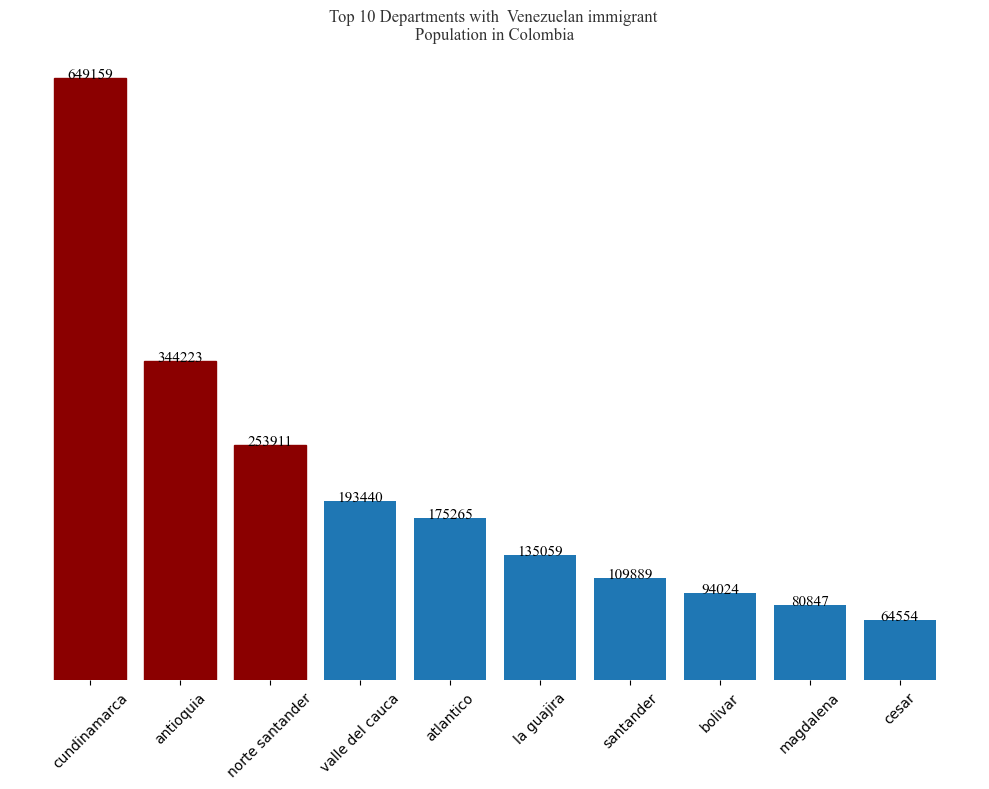

In [45]:
plt.figure(figsize=(10, 8));

bars = plt.bar(top_10['department'],top_10['inmigrant population'], align='center');

bars[0].set_color('#8B0000')
bars[1].set_color('#8B0000')
bars[2].set_color('#8B0000')

plt.xticks(rotation=45);

plt.yticks([])

plt.title('Top 10 Departments with  Venezuelan immigrant \nPopulation in Colombia', alpha=0.8, fontname="Times New Roman")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, str(int(height)),
                ha='center', color='black', fontsize=11, fontname="Times New Roman")

In [39]:
top_10l = df2
top_10l.sort_values(['FEB'], ascending=False)
top_10l = top_10l.nsmallest(10, 'FEB')

In [40]:
top10 = df4

In [41]:
top10 = top10.nlargest(10, 'temperature(celsius)')
top10['inmigrant population'] = top10['inmigrant population']

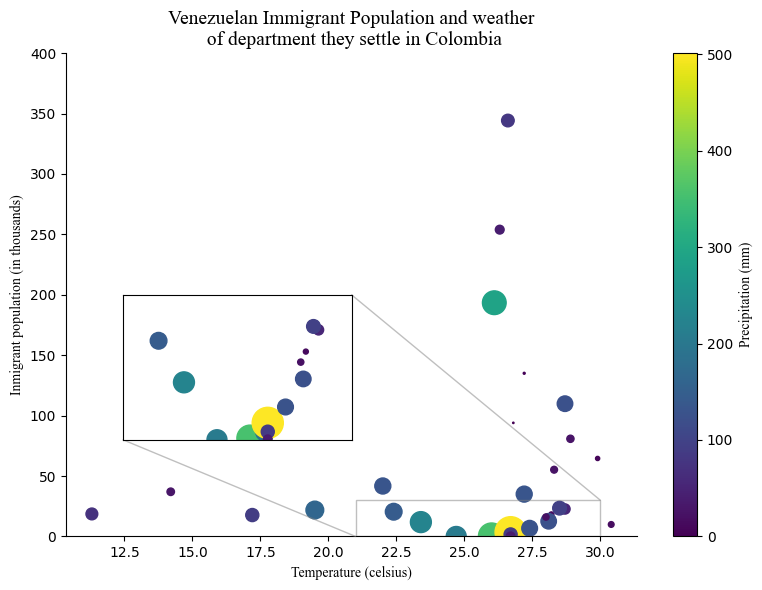

In [48]:
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
scatter = ax1.scatter(df4['temperature(celsius)'], df4['inmigrant population']/1000, 
                      c=df4['mm rain'], cmap='viridis', s=df4['mm rain'])  # Adjust 'cmap' and 's' parameters as desired

axins = ax1.inset_axes([0.1, 0.2, 0.4, 0.3])
axins.set(xlim=(21, 30), ylim=(0, 30), xticks=[], yticks=[])
ax1.indicate_inset_zoom(axins)
axins.scatter(df4['temperature(celsius)'], df4['inmigrant population']/1000, 
                      c=df4['mm rain'], cmap='viridis', s=df4['mm rain'])


plt.ylim(0, 400)
plt.xlabel('Temperature (celsius)', fontname="Times New Roman")
plt.ylabel('Inmigrant population (in thousands)', fontname="Times New Roman")
plt.title('Venezuelan Immigrant Population and weather\n of department they settle in Colombia',fontsize=14, fontname="Times New Roman")

cbar = plt.colorbar(scatter)
cbar.set_label('Precipitation (mm)', fontname="Times New Roman")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()